# **Title**

# Introduction

# Methods & Results 

## Loading in Libraries & Reading in Data

Before we begin coding, we must load the required libaries for R.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(digest)
library(repr)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

Next, we will begin reading the file into JupyterHub. Since the file is retrieved from an outside URL, we will download the file to JupyterHub, and since the cells are seperated by semi-colons, instead of normally reading the file through read_csv, we will read the file by read_csv2.

In [2]:
#reading the data
temp <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip",temp)

#Reading the data in R
facebook <- read_csv2(unz(temp, "dataset_Facebook.csv"))
head(facebook)
unlink(temp)

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Parsed with column specification:
cols(
  `Page total likes` = col_double(),
  Type = col_character(),
  Category = col_double(),
  `Post Month` = col_double(),
  `Post Weekday` = col_double(),
  `Post Hour` = col_double(),
  Paid = col_double(),
  `Lifetime Post Total Reach` = col_double(),
  `Lifetime Post Total Impressions` = col_double(),
  `Lifetime Engaged Users` = col_double(),
  `Lifetime Post Consumers` = col_double(),
  `Lifetime Post Consumptions` = col_double(),
  `Lifetime Post Impressions by people who have liked your Page` = col_double(),
  `Lifetime Post reach by people who like your Page` = col_double(),
  `Lifetime People who have liked your Page and engaged with your post` = col_double(),
  comment = col_double(),
  like = col_double(),
  share = col_double(),
  `Total Interactions` = col_double()
)



Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139441,Photo,2,12,4,3,0,2752,5091,178,109,159,3078,1640,119,4,79,17,100
139441,Status,2,12,3,10,0,10460,19057,1457,1361,1674,11710,6112,1108,5,130,29,164
139441,Photo,3,12,3,3,0,2413,4373,177,113,154,2812,1503,132,0,66,14,80
139441,Photo,2,12,2,10,1,50128,87991,2211,790,1119,61027,32048,1386,58,1572,147,1777
139441,Photo,2,12,2,3,0,7244,13594,671,410,580,6228,3200,396,19,325,49,393
139441,Status,2,12,1,9,0,10472,20849,1191,1073,1389,16034,7852,1016,1,152,33,186


Figure 1: Initial Dataset of Table

Looking at our dataset, it passes the test for tidy data (each row is a single observation, each column is a single variable, each value is a single cell), so no further cleaning data tools are required. However, the variable names are separated by white spaces instead of underscores (_). To deal with this issue, we will rename our predictor columns to avoid additional headaches along the way. 

In [3]:
#Renaming "Post Hour"
facebook_1 <- facebook %>% rename(post_hour = `Post Hour`) %>% 
    rename(post_day = `Post Weekday`) %>% 
    rename(total_interactions = `Total Interactions`)

## Exploratory Data Analysis and Splitting Data

As part of our exploratory data analysis, we'll take a quick overview of our predictor variable, plotting "Total Interactions" against a time variable (In this case, we'll use Post Hour) through a scatterplot, just to filter out any potential outliers in our data.

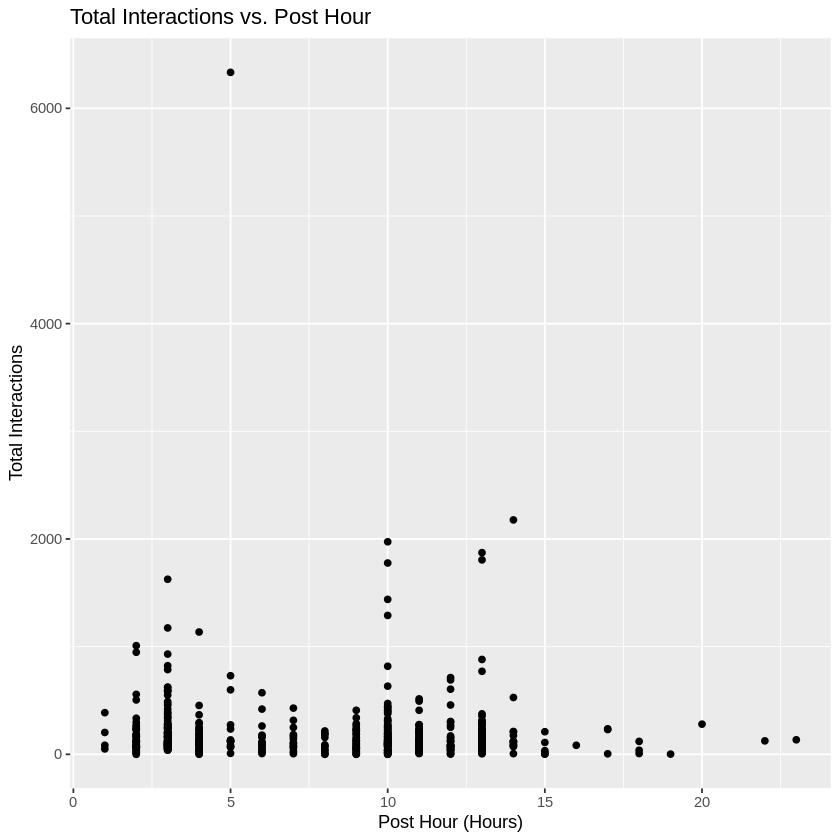

In [4]:
exploratory_scatter_plot <- ggplot(facebook_1, aes(x = post_hour, y = total_interactions)) +
                            geom_point() +
                            labs(x = "Post Hour (Hours)", y = "Total Interactions", title = "Total Interactions vs. Post Hour") 
exploratory_scatter_plot

Figure 2: Exploratory Scatter Plot

Hmmm. It seems here that there is one post that has more than six thousand total interactions, with only around ten posts that have more than a thousand total interactions. These outliers can cause implications as it can skew the results of our data (large standard deviations) and make our graph look silly, like in the example above. Therefore, let's filter our total interactions to be less than a thousand to retrieve the most optimal results when we perform our regression models. And as stated in our introduction, let's also create a new variable for the hour of the week through the mutate function.

In [5]:
set.seed(2021)
facebook_filtered_interactions <- facebook_1 %>% filter(total_interactions < 1000) %>% 
    mutate(hour_of_week = (post_day - 1) * 24 + post_hour)
facebook_filtered_interactions

Page total likes,Type,Category,Post Month,post_day,post_hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,total_interactions,hour_of_week
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139441,Photo,2,12,4,3,0,2752,5091,178,109,159,3078,1640,119,4,79,17,100,75
139441,Status,2,12,3,10,0,10460,19057,1457,1361,1674,11710,6112,1108,5,130,29,164,58
139441,Photo,3,12,3,3,0,2413,4373,177,113,154,2812,1503,132,0,66,14,80,51
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
81370,Photo,1,1,5,2,0,3778,7216,625,572,795,4742,2388,363,4,93,18,115,98
81370,Photo,3,1,4,11,0,4156,7564,626,574,832,4534,2452,370,7,91,38,136,83
81370,Photo,2,1,4,4,NA,4188,7292,564,524,743,3861,2200,316,0,91,28,119,76


Figure  3: Filtering of Total Interactions and Addition of Post_Week Variable Table

Here we check that we have included our hour_of_week variable properly into the dataset, and sure enough, it is.

Next, let's build our exploratory table of our training dataset that we will be performing our K-Nearest Neighbors Regression on, which includes the number of rows, the number of columns and the number of rows with missing data values. However, to find to the means to our predictor variables (likes, comments, shares, and our total interactions), we will also need to filter out the number of rows with missing data values, so that we would not encounter any problems (such as a "NA" result) when finding the average. Altogether, we will mutate each of the results we found into one big table in the end.

In [6]:
set.seed(2021)

#Filtering missing data
facebook_filtered_na <- facebook_filtered_interactions %>%
                            filter(!is.na(Paid)) %>% 
                            filter(!is.na(comment)) %>% 
                            filter(!is.na(like)) %>% 
                            filter(!is.na(share)) %>%                          
                            filter(!is.na(total_interactions))

#Missing Rows of Data
missing_rows <- sum(colSums(is.na(facebook)))

#Average of Each Predictor Variable
average_likes <- mean(facebook_filtered_na[["like"]])
average_comments <- mean(facebook_filtered_na[["comment"]])
average_shares <- mean(facebook_filtered_na[["share"]])
average_total_interactions <- mean(facebook_filtered_na[["total_interactions"]])

#Total Number of Observations
observation_total <- nrow(facebook_filtered_na)

#Total Number of Variables
variable_total <- ncol(facebook_filtered_na)

#Exploratory Data Analysis Table
exploratory_table <- facebook_filtered_na %>%
                     mutate(facebook_filtered_na, observation_total = observation_total) %>%
                     mutate(facebook_filtered_na, variable_total = variable_total) %>%
                     mutate(facebook_filtered_na, average_likes = average_likes) %>%
                     mutate(facebook_filtered_na, average_comments = average_comments) %>%
                     mutate(facebook_filtered_na, average_shares = average_shares) %>%
                     mutate(facebook_filtered_na, average_total_interactions = average_total_interactions) %>%
                     mutate(facebook_filtered_na, missing_rows = missing_rows) %>%
                     select(observation_total, variable_total, average_likes, average_comments, average_shares, average_total_interactions,
                            missing_rows) %>%
                     slice(1)
exploratory_table

observation_total,variable_total,average_likes,average_comments,average_shares,average_total_interactions,missing_rows
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
483,20,141.2733,5.621118,23.49689,170.3913,6


Figure 4: Exploratory Data Analysis Table

Based on these results of our exploratory table, we can notice a few things. First off, there are 483 observations, meaning that theres a lot of data to process! This means that regardless of the amount of folds specified for cross validation, our accuracy of our regression model won't be perfect. Our results will only provide a rough estimate of the true results, which will be sufficient enough for answering our question. Also to keep in mind is the average of total interactions, which will serve as a baseline later when we compare our data visualization with some of the numbers in this data exploratory table


Next, let's create a quick visualization of our dataset of our predictor and target variables (total interactions and hour of week) through the function ggpairs. 

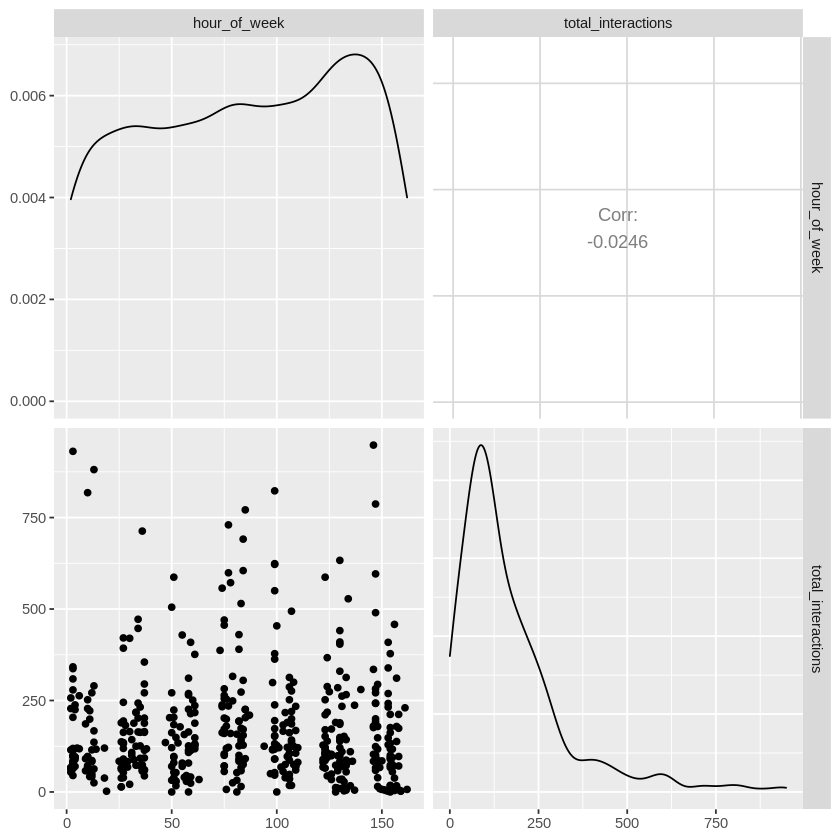

In [7]:
facebook_ggpairs2 <- facebook_filtered_interactions %>%
    select(hour_of_week, total_interactions) %>% 
    ggpairs()
facebook_ggpairs2

Figure  5: Ggpairs Dataset between Hour_of_Week and Total_Interactions  

Looking at the relationship between Hour of Week and Total Interactions, there seems to have no correlation between the two variables. This means as that as the week progresses, this does not affect the number of total interactions, and vice versa. While this may serve as an intial prediction, explore more affecing our results**

## Regression

As we are clearly predicting a numerical value, this is a regression problem, predicting the highest engagement based on the hour of the week. As with any regression or classification model at the start, we'll split the data into training and testing data, setting aside 75 percent for the training data set and 25 percent with our testing data set, and setting our strata to be our target variable, which is total interactions.

We will be using both K-nearest neighbours regression and simple linear regression to answer our problem.

In [8]:
#Split into training (75 percent of data set) and test data
set.seed(2021)
facebook_split <- initial_split(facebook_filtered_na, prop = 0.75, strata = total_interactions)
facebook_train <- training(facebook_split)
facebook_test <- testing(facebook_split)

### K-nearest Neighbour Regression

Let's begin finding the most optimal K for our regression model. First we'll build a recipe and model specification, setting aside the variables required for our analysis, and as a good measure scaling our predictors for our recipe. We'll also set the neighbors to "tune" and mode to "regression" for our model specification. 

In [9]:
set.seed(2021)
#Recipe for Post Hour
facebook_recipe <- recipe(total_interactions ~ hour_of_week, data = facebook_train) %>%
                   step_scale(all_predictors()) %>%
                   step_center(all_predictors())
#Model
facebook_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                 set_engine("kknn") %>%
                 set_mode("regression")

Next, let's use cross-validation for five folds, and begin creating our workflow by adding our recipe and model. Next, we'll want to test 200 values of K by creating a tibble containing a sequence of 200 rows of K. Finally, we'll tune our workflow with the 200 values of K from gridivals, and make sure it resamples in our cross-validation data set.

In [10]:
set.seed(2021)
#5 fold cross validation
facebook_vfold <- vfold_cv(facebook_train, v = 5, strata = total_interactions)

#workflow
facebook_workflow <- workflow() %>%
                     add_recipe(facebook_recipe) %>%
                     add_model(facebook_spec)

#testing 200 values to find the best value for K
gridvals <- tibble(neighbors = seq(1, 200))

#tuning workflow and resampling cross validation data set
facebook_results <- facebook_workflow %>%
                        tune_grid(resamples = facebook_vfold, grid = gridvals) %>%
                        collect_metrics()

Lastly, we'll filter for our min RMSE to help us find our most optimal K.

In [11]:
#Min amount of RMSPE along with mean and standard error to find the best K value to use
facebook_min <- facebook_results %>%
    filter(.metric == "rmse") %>%
    arrange(mean)  %>% 
    slice(1)

facebook_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
93,rmse,standard,161.1096,5,5.728928,Model093


Figure 6: Min Number of Neighbors

With our most optimal K, lets finally repeat the steps earlier, using the k_min as our nearest neigbours, refiting our knn regression model, and predicting the model using  test data instead of training data.

In [12]:
#Min RMSPE
set.seed(2021)
k_min <- facebook_min %>%
            pull(neighbors)

#Using the best K in our model
facebook_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
                            set_engine("kknn") %>%
                            set_mode("regression")

#Reworking the workflow to incorporate our chosen K
facebook_best_fit <- workflow() %>%
                        add_recipe(facebook_recipe) %>%
                        add_model(facebook_best_spec) %>%
                        fit(data = facebook_train)

#Summary of the training vs testing data
facebook_summary <- facebook_best_fit %>% 
                       predict(facebook_test) %>%
                       bind_cols(facebook_test) %>%
                       metrics(truth = total_interactions, estimate = .pred)  
facebook_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,134.92938185
rsq,standard,0.04724075
mae,standard,105.24731183


The $RMSPE$ value is from our testing data set is 134.92, which is lower than 161.1096, the $RMSPE$ value for the cross-validation of our best mode. This means that our model is better on the test data than on the training data.

In [ ]:
#set.seed(2021)
facebook_preds <-  facebook_best_fit %>%
                   predict(facebook_test) %>%
                   bind_cols(facebook_test)
facebook_plot_final <- ggplot(facebook_preds, aes(x = hour_of_week, y = total_interactions)) +
                       geom_point(alpha = 0.4) +
                       xlab("Hour of Week") +
                       ylab("Total Interactions (Sum of Likes, Comments, and Shares)") +
                       geom_line(data = facebook_preds, aes(x = hour_of_week, y = .pred), color = "blue") +
                       ggtitle(paste0("K = ", k_min))
facebook_plot_final

Figure 7: Final Graph between Total Interactions and Hour of Week

In [ ]:
#function that converts post_day (weekday as a number from 1 to 7) to name of day
weekday_no_to_name <- function(day_num) {
    day <- switch(day_num, "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday")
    return(day)
}

In [ ]:
# Show post hours, weekdays with highest post stats
facebook_best <- facebook_preds %>% 
    select(.pred, post_day, post_hour, hour_of_week) %>%
    group_by(hour_of_week, post_day, post_hour) %>%
    summarize(predicted_interactions = mean(.pred)) %>% # same hour and weekday have same prediction; used summarize to remove duplicates
    mutate(post_day = map(post_day, weekday_no_to_name)) %>% # convert weekday numbers to weekday names
    arrange(desc(predicted_interactions))
head(facebook_best)

### Linear Regression

KNN Regression isn't the only method for prediction quantatative values. Another method is Linear Regression, which instead of looking at the K-nearest neighbours and averaging over their values for a prediction, we use all the training data points to create a straight line of best fit. This line is then used to "look up" the predicted value. This different prediction method may give us more accurate results, so we will be creating a linear regression model for further analysis and comparison to our KNN model later on in the report.

Using our training data from before, we start by creating a new model specification that sets the engine to "lm" and the mode to "regression" (like before) and a new recipe. Unlike the KNN Facebook recipe, we do not need to scale and center the data for linear regression as standardization does not affect the fit of the model at all. It does impact the coefficients in the linear slope equation though, but its usually easier to interpret the best fit coefficients if we don't standardize so we're choosing not to.

In [16]:
fb_spec <- linear_reg() %>%
    set_engine("lm") %>%
    set_mode("regression")

fb_recipe <- recipe(total_interactions ~ hour_of_week, data = facebook_train)

fb_fit <- workflow() %>%
    add_recipe(fb_recipe) %>%
    add_model(fb_spec) %>%
    fit(data = facebook_train)
fb_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
 (Intercept)  hour_of_week  
   175.02958      -0.00181  


From the given model, we see that our coefficients are (intercept) β0 = 175.02958, and (slope) β1 = -0.00181. This gives us a slope equation of:

$ total \ interactions = 175.02958 - 0.00181 * hour \ of \ week$

The model is predicting that interactions roughly start at 180.85, and every hour_of_week decreases total interactions by 0.00181. This fits our exploratory analysis earlier, where we initially discovered that there is no correlation between hour_of_week and total interactions.

Next, we calculate the $RMSE$  to assess goodness of fit on fb_fit. This tells us how well our linear regression model predicts on the training data used to fit the model.

In [20]:
lm_rmse <- fb_fit %>%
         predict(facebook_train) %>%
         bind_cols(facebook_train) %>%
         metrics(truth = total_interactions, estimate = .pred) %>%
         filter(.metric == "rmse") %>%
         select(.estimate)  %>%
         pull()
lm_rmse

[1] 162.5757

We also calculate the $RMSPE$ using our training data

In [21]:
fb_test_results <- fb_fit %>%
    predict(facebook_test) %>%
    bind_cols(facebook_test) %>%
    metrics(truth = total_interactions, estimate = .pred) %>%
         filter(.metric == "rmse") %>%
         select(.estimate)  %>%
         pull()

fb_test_results

[1] 137.321

The $RMSPE$ value is from our testing data set is 137.32, which is lower than 162.58, the $RMSE$ value. This means that our model is better on the test data than on the training data.
<br> <br>
The next and final step is to graph the relationship.

In [ ]:
facebook_plot_final <- ggplot(facebook_linear_preds, aes(x = hour_of_week, y = total_interactions)) +
                       geom_point(alpha = 0.1) +
                       xlab("Hour of week") +
                       ylab("Total Interactions (Sum of Likes, Comments, and Shares)") +
                       geom_line(data = facebook_linear_preds, aes(x = hour_of_week, y = .pred), color = "blue") +
                       ggtitle("The Predicted Relationship between 
Total Interactions and the Hour of Week") +
                       theme(text = element_text(size = 16)) 
facebook_plot_final

The visualization of the model affirms what our model was predicting earlier; the correlation between Total Interactions and Hour of Week is minimal. The slope of the line is nearly zero, indicating that the relationship is very weak, but it is still a weak negative slope. This does show that there is a relationship between the two variables, but this relationship serves no purpose for predictive analysis.

# Discussion

# References